# BERT and Sentiment Treebank

Fine-tuning code based on [this](https://medium.com/@aniruddha.choudhury94/part-2-bert-fine-tuning-tutorial-with-pytorch-for-text-classification-on-the-corpus-of-linguistic-18057ce330e1)

In [1]:
import os
import random

import pandas as pd
import numpy as np
import scipy as sp
import torch
import spacy
from torch.utils.data import \
    TensorDataset, \
    DataLoader
from transformers import \
    BertTokenizer, \
    BertForSequenceClassification, \
    AdamW, \
    BertConfig, \
    get_linear_schedule_with_warmup
import pytreebank
from tqdm import tqdm
import shap
from checklist.perturb import Perturb

In [2]:
os.chdir('../..')

## Load data

In [2]:
dataset = pytreebank.load_sst("data/raw/stanford_sentiment_treebank/")

In [3]:
train = dataset['train']
dev = dataset['dev']
# test = dataset['test']

In [4]:
def stanford_raw_to_df(pytree_dataset):
    """
    Convert list of pytreebank LabeledTree objects to DataFrame of full-sentence examples with labels
    """
    labels = []
    sentences = []
    
    for labeled_tree_obj in pytree_dataset:
        lab, sent = labeled_tree_obj.to_labeled_lines()[0]  # First index contains full sentence
        labels.append(lab)
        sentences.append(sent)
        
    output_df = pd.DataFrame(
        {
            'sentence': sentences,
            'label': labels
        }
    )
    
    return output_df

In [5]:
train_df = stanford_raw_to_df(train)
print(train_df.shape)
train_df.head()

(8544, 2)


,sentence,label
0,The Rock is destined to be the 21st Century 's...,3
1,The gorgeously elaborate continuation of `` Th...,4
2,Singer/composer Bryan Adams contributes a slew...,3
3,You 'd think by now America would have had eno...,2
4,Yet the act is still charming here .,3


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8544 entries, 0 to 8543
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  8544 non-null   object
 1   label     8544 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 133.6+ KB


In [7]:
dev_df = stanford_raw_to_df(dev)
print(dev_df.shape)
dev_df.head()

(1101, 2)


,sentence,label
0,It 's a lovely film with lovely performances b...,3
1,"No one goes unindicted here , which is probabl...",2
2,And if you 're not nearly moved to tears by a ...,3
3,"A warm , funny , engaging film .",4
4,Uses sharp humor and insight into human nature...,4


## Pre-processing

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [10]:
train_encoded_sentences = []

for sentence in train_df['sentence'].values:
    enc_sent_as_list = tokenizer.encode(sentence, add_special_tokens=True)
    train_encoded_sentences.append(enc_sent_as_list)

In [11]:
train_df.loc[2]['sentence']

'Singer/composer Bryan Adams contributes a slew of songs -- a few potential hits , a few more simply intrusive to the story -- but the whole package certainly captures the intended , er , spirit of the piece .'

In [12]:
[tokenizer.convert_ids_to_tokens(i_d) for i_d in train_encoded_sentences[2]]

['[CLS]',
 'singer',
 '/',
 'composer',
 'bryan',
 'adams',
 'contributes',
 'a',
 'sl',
 '##ew',
 'of',
 'songs',
 '-',
 '-',
 'a',
 'few',
 'potential',
 'hits',
 ',',
 'a',
 'few',
 'more',
 'simply',
 'int',
 '##rus',
 '##ive',
 'to',
 'the',
 'story',
 '-',
 '-',
 'but',
 'the',
 'whole',
 'package',
 'certainly',
 'captures',
 'the',
 'intended',
 ',',
 'er',
 ',',
 'spirit',
 'of',
 'the',
 'piece',
 '.',
 '[SEP]']

In [13]:
dev_encoded_sentences = []

for sentence in dev_df['sentence'].values:
    enc_sent_as_list = tokenizer.encode(sentence, add_special_tokens=True)
    dev_encoded_sentences.append(enc_sent_as_list)

In [14]:
max([len(sent) for sent in train_encoded_sentences]), max([len(sent) for sent in dev_encoded_sentences])

(66, 55)

In [15]:
def pad_sentence_at_end(sentence, max_length):
    """
    Pad tokenised sentence with zeros at end
    
    :param: sentence: list of encodings for a sentence
    :param: max_length: max length to pad up to
    """
    num_zeros_to_add = max_length - len(sentence)
    zero_list = list(
        np.zeros(num_zeros_to_add).astype(int)
    )
    padded_sentence = sentence + zero_list
    return np.array(padded_sentence)


def create_sentence_input_arrays(list_encoded_sentences, max_length):
    """
    Create input arrays for BERT
    
    :param: list_encoded_sentences: List of sentence encoding lists
    :param: max_length: max length to pad up to
    """
    encoded_sentences = [pad_sentence_at_end(sent, max_length) for sent in list_encoded_sentences]
    
    train_array = np.vstack(encoded_sentences)
    
    train_attention_mask_array = (train_array != 0).astype(int)
    
    return train_array, train_attention_mask_array

In [16]:
MAX_LENGTH = 70

train_array, train_attention_mask_array = create_sentence_input_arrays(
    train_encoded_sentences, 
    MAX_LENGTH
)

dev_array, dev_attention_mask_array = create_sentence_input_arrays(
    dev_encoded_sentences, 
    MAX_LENGTH
)

In [17]:
train_array.shape, train_attention_mask_array.shape

((8544, 70), (8544, 70))

In [18]:
dev_array.shape, dev_attention_mask_array.shape

((1101, 70), (1101, 70))

In [19]:
np.array(train_encoded_sentences[0])

array([  101,  1996,  2600,  2003, 16036,  2000,  2022,  1996,  7398,
        2301,  1005,  1055,  2047,  1036,  1036, 16608,  1005,  1005,
        1998,  2008,  2002,  1005,  1055,  2183,  2000,  2191,  1037,
       17624,  2130,  3618,  2084,  7779, 29058,  8625, 13327,  1010,
        3744,  1011, 18856, 19513,  3158,  5477,  4168,  2030,  7112,
       16562,  2140,  1012,   102])

In [20]:
train_array[0]

array([  101,  1996,  2600,  2003, 16036,  2000,  2022,  1996,  7398,
        2301,  1005,  1055,  2047,  1036,  1036, 16608,  1005,  1005,
        1998,  2008,  2002,  1005,  1055,  2183,  2000,  2191,  1037,
       17624,  2130,  3618,  2084,  7779, 29058,  8625, 13327,  1010,
        3744,  1011, 18856, 19513,  3158,  5477,  4168,  2030,  7112,
       16562,  2140,  1012,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0])

In [21]:
train_attention_mask_array[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

Convert to tensors

In [22]:
train_tensor = torch.tensor(train_array)
train_attention_mask_tensor = torch.tensor(train_attention_mask_array)
train_labels_tensor = torch.tensor(train_df['label'].values)

dev_tensor = torch.tensor(dev_array)
dev_attention_mask_tensor = torch.tensor(dev_attention_mask_array)
dev_labels_tensor = torch.tensor(dev_df['label'].values)

## Fine-tune BERT

Run on Colab

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [30]:
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
EPS = 1e-8
RANDOM_SEED = 3
NUM_EPOCHS = 2

In [31]:
train_dataset = TensorDataset(train_tensor, train_attention_mask_tensor, train_labels_tensor)
dev_dataset = TensorDataset(dev_tensor, dev_attention_mask_tensor, dev_labels_tensor)

In [32]:
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_data_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)

https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification

In [33]:
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=5,
    output_attentions=False,
    output_hidden_states=False
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [34]:
%%capture
bert_model.to(device)

In [35]:
optimiser = AdamW(
    bert_model.parameters(),
    lr=LEARNING_RATE,
    eps=EPS
)

In [36]:
scheduler = get_linear_schedule_with_warmup(
    optimiser, 
    num_warmup_steps=0,
    num_training_steps=len(train_data_loader) * NUM_EPOCHS
)

In [65]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

for epoch in range(NUM_EPOCHS):
    
    #========================================#
    # TRAINING                               #
    #========================================#
    
    bert_model.train()
    
    for batch in tqdm(train_data_loader):
        
        batch_input_ids = batch[0].to(device)
        batch_attention_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)

        optimiser.zero_grad()  # Set gradients to 0 otherwise will accumulate

        outputs = bert_model(
            input_ids=batch_input_ids,
            token_type_ids=None,
            attention_mask=batch_attention_mask,
            labels=batch_labels
        )
        
        loss = outputs[0]
        
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)
        
        optimiser.step()
        scheduler.step()
        
    #========================================#
    # EVALUATE                               #
    #========================================#  
    
    bert_model.eval()
    
    # Train accuracy:
    train_pred_labels = []
    train_labels = []
    
    for batch in train_data_loader:
        
        batch_input_ids = batch[0].to(device)
        batch_attention_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)
        
        with torch.no_grad():
            outputs = bert_model(
                input_ids=batch_input_ids,
                token_type_ids=None,
                attention_mask=batch_attention_mask
            )
            
        logits = outputs[0]
        
        batch_pred_labels = list(
            torch.argmax(logits, dim=1).cpu().numpy()
        )
        train_pred_labels = train_pred_labels + batch_pred_labels
        
        batch_labels = list(
            batch_labels.cpu().numpy()
        )
        train_labels = train_labels + batch_labels
    
    train_accuracy = (np.array(train_pred_labels) == np.array(train_labels)).mean()
    
    
    # Dev accuracy:
    dev_pred_labels = []
    dev_labels = []
    
    for batch in dev_data_loader:
        
        batch_input_ids = batch[0].to(device)
        batch_attention_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)
        
        with torch.no_grad():
            outputs = bert_model(
                input_ids=batch_input_ids,
                token_type_ids=None,
                attention_mask=batch_attention_mask
            )
            
        logits = outputs[0]
        
        batch_pred_labels = list(
            torch.argmax(logits, dim=1).cpu().numpy()
        )
        dev_pred_labels = dev_pred_labels + batch_pred_labels
        
        batch_labels = list(
            batch_labels.cpu().numpy()
        )
        dev_labels = dev_labels + batch_labels
    
    dev_accuracy = (np.array(dev_pred_labels) == np.array(dev_labels)).mean()
    
    print(f"Epoch {epoch+1}: train_acc={train_accuracy}, dev_acc={dev_accuracy}")

## Save model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
os.getcwd()

May need to change current directory

In [ ]:
bert_model.save_pretrained("Colab Notebooks/fine-tuned-bert-base-sst")

Download and save to models folder

# SHAP

Based on this [guide](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Emotion%20Classification%20Explanation%20Demo.html)

## Load model

In [10]:
bert_model = BertForSequenceClassification.from_pretrained("models/fine-tuned-bert-base-sst")

In [40]:
bert_model.eval()

# Dev accuracy:
dev_pred_labels = []
dev_labels = []

for batch in tqdm(dev_data_loader):

    batch_input_ids = batch[0].to(device)
    batch_attention_mask = batch[1].to(device)
    batch_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = bert_model(
            input_ids=batch_input_ids,
            token_type_ids=None,
            attention_mask=batch_attention_mask
        )

    logits = outputs[0]

    batch_pred_labels = list(
        torch.argmax(logits, dim=1).cpu().numpy()
    )
    dev_pred_labels = dev_pred_labels + batch_pred_labels

    batch_labels = list(
        batch_labels.cpu().numpy()
    )
    dev_labels = dev_labels + batch_labels

dev_accuracy = (np.array(dev_pred_labels) == np.array(dev_labels)).mean()
dev_accuracy

100%|██████████| 35/35 [02:18<00:00,  3.97s/it]


0.5213442325158947

In [11]:
train_df.head()

,sentence,label
0,The Rock is destined to be the 21st Century 's...,3
1,The gorgeously elaborate continuation of `` Th...,4
2,Singer/composer Bryan Adams contributes a slew...,3
3,You 'd think by now America would have had eno...,2
4,Yet the act is still charming here .,3


In [12]:
# set mapping between label and id
id2label = bert_model.config.id2label
label2id = bert_model.config.label2id
labels = sorted(label2id, key=label2id.get)

## Label distribution

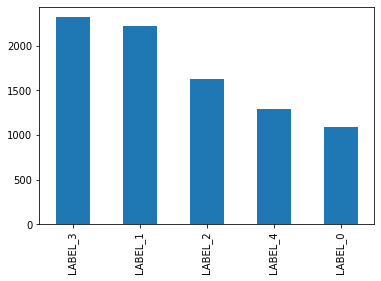

In [14]:
ax = train_df.label.map(id2label).value_counts().plot.bar()

## Define function

In [27]:
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128,truncation=True) for v in x])  # .cuda()
    attention_mask = (tv!=0).type(torch.int64)  # .cuda()
    outputs = bert_model(tv,attention_mask=attention_mask)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

Create an explainer object

In [28]:
explainer = shap.Explainer(f,tokenizer,output_names=labels)

Compute SHAP values

In [30]:
shap_values = explainer(train_df['sentence'][0:10])

  0%|          | 0/48 [00:00<?, ?it/s]



Partition explainer:  10%|█         | 1/10 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]



Partition explainer:  30%|███       | 3/10 [00:27<00:47,  6.83s/it]

  0%|          | 0/48 [00:00<?, ?it/s]



Partition explainer:  16%|█▌        | 8/50 [02:35<15:34, 22.25s/it]


  0%|          | 0/48 [00:00<?, ?it/s]



Partition explainer:  50%|█████     | 5/10 [00:53<00:54, 10.97s/it]

  0%|          | 0/48 [00:00<?, ?it/s]



Partition explainer:  60%|██████    | 6/10 [01:07<00:47, 11.78s/it]

  0%|          | 0/48 [00:00<?, ?it/s]



Partition explainer:  70%|███████   | 7/10 [01:20<00:36, 12.29s/it]

  0%|          | 0/48 [00:00<?, ?it/s]



Partition explainer:  80%|████████  | 8/10 [01:33<00:25, 12.60s/it]

  0%|          | 0/48 [00:00<?, ?it/s]



Partition explainer:  90%|█████████ | 9/10 [01:47<00:12, 12.81s/it]

  0%|          | 0/48 [00:00<?, ?it/s]



Partition explainer: 100%|██████████| 10/10 [02:00<00:00, 12.94s/it]

  0%|          | 0/48 [00:00<?, ?it/s]



Partition explainer: 11it [02:13, 13.36s/it]                        


Top words contributing to a given label:

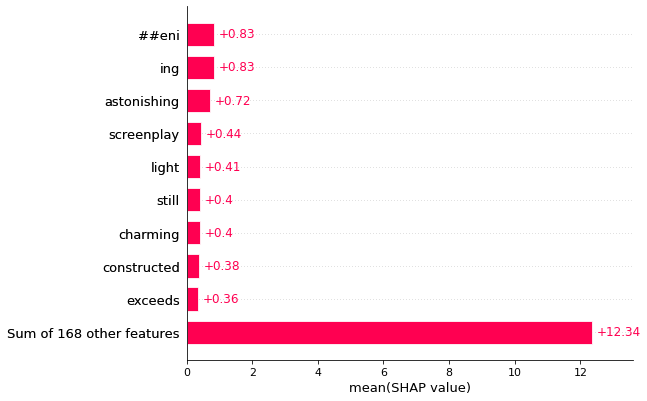

In [57]:
shap.plots.bar(shap_values[:,:,"LABEL_4"].mean(0))

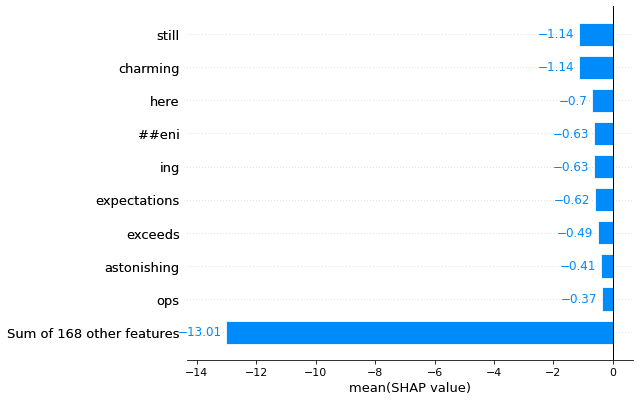

In [63]:
shap.plots.bar(shap_values[:,:,"LABEL_0"].mean(0))

In [70]:
shap.plots.text(shap_values[1, :, "LABEL_4"])

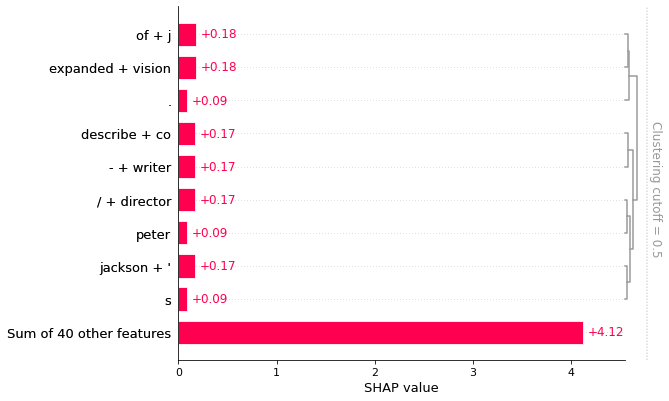

In [55]:
shap.plots.bar(shap_values[1, :, "LABEL_4"])

In [65]:
pd.DataFrame(
    {
        'shap_values': shap_values[1, :, "LABEL_4"].values,
        'token': shap_values[1, :, "LABEL_4"].data
    }
).sort_values('shap_values', ascending=False).head(10)

,shap_values,token
52,0.138969,earth
51,0.138969,-
53,0.138969,.
47,0.138969,tolkien
48,0.138969,'
50,0.138969,middle
49,0.138969,s
9,0.120793,the
10,0.120793,lord
11,0.120793,of


In [105]:
# shap.plots.text(shap_values[:3])

# Checklist

Follows examples from [here](https://github.com/marcotcr/checklist/blob/master/notebooks/tutorials/2.%20Perturbing%20data.ipynb)

## General prediction function

In [19]:
BATCH_SIZE = 32
MAX_LENGTH = 70

In [16]:
def make_predictions(df, model, tokenizer, sentence_col_name):

    #==========================================#
    # PREPARE DATA                             #
    #==========================================#

    df = df.copy()

    encoded_sentences = []

    for sentence in df['sentence'].values:
        enc_sent_as_list = tokenizer.encode(sentence, add_special_tokens=True)
        encoded_sentences.append(enc_sent_as_list)

    input_array, input_attention_mask_array = create_sentence_input_arrays(
        encoded_sentences, 
        MAX_LENGTH
    )

    input_tensor = torch.tensor(input_array)
    input_attention_mask_tensor = torch.tensor(input_attention_mask_array)
    input_labels_tensor = torch.tensor(df['label'].values)

    input_dataset = TensorDataset(input_tensor, input_attention_mask_tensor, input_labels_tensor)

    input_data_loader = DataLoader(input_dataset, batch_size=BATCH_SIZE)

    #==========================================#
    # RUN MODEL                                #
    #==========================================#

    model.eval()

    predicted_labels = []

    for batch in tqdm(input_data_loader):

        batch_input_ids = batch[0].to(device)
        batch_attention_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=batch_input_ids,
                token_type_ids=None,
                attention_mask=batch_attention_mask
            )

        logits = outputs[0]

        batch_pred_labels = list(
            torch.argmax(logits, dim=1).cpu().numpy()
        )
        predicted_labels = predicted_labels + batch_pred_labels

    return np.array(predicted_labels)

In [20]:
train_predictions = make_predictions(train_df, bert_model, tokenizer, 'sentence')

100%|██████████| 267/267 [00:18<00:00, 14.62it/s]


In [21]:
train_df['predictions'] = train_predictions

In [22]:
train_df.head()

,sentence,label,predictions
0,The Rock is destined to be the 21st Century 's...,3,4
1,The gorgeously elaborate continuation of `` Th...,4,4
2,Singer/composer Bryan Adams contributes a slew...,3,3
3,You 'd think by now America would have had eno...,2,1
4,Yet the act is still charming here .,3,3


## Checklist perturbations

In [106]:
%%capture
!python -m spacy download en_core_web_sm

In [18]:
nlp = spacy.load('en_core_web_sm')

Notes:
- `strip_punctuation` removes punctuation at end of sentence only
- Need to set seed as perturbations are random
- `contract` doesn't always do contraction

In [86]:
def add_checklist_perturbations(
    df, sentence_col_name, strip_punct=True, add_typos=True, contract_sent=True, change_names=True, seed=3
):
    df = df.copy()
    
    np.random.seed(seed)  # Set seed as some perturbations are stochastic
    
    if strip_punct or change_names:
        # Checklist requires pre-processing with Spacy for these perturbations
        pdata = list(nlp.pipe(df[sentence_col_name]))
    
    # Strip trailing punctuation
    
    if strip_punct:
        
        stripped_sentences = [Perturb.strip_punctuation(pdata[i]) for i in range(len(pdata))]
        
        df[sentence_col_name + '_strip_punct'] = stripped_sentences
        
        # Create success flag as not all sentences will contain punctuation:
        df['success_strip_punct'] = np.where(
            df[sentence_col_name + '_strip_punct'] != df[sentence_col_name],
            1,
            0
        )
    
    # Add typos
    
    if add_typos:
        sentences_w_typos = [Perturb.add_typos(df[sentence_col_name][i]) for i in range(len(df))]
        
        df[sentence_col_name + '_add_typos'] = sentences_w_typos
        
        # Create success flag
        df['success_add_typos'] = np.where(
            df[sentence_col_name + '_add_typos'] != df[sentence_col_name],
            1,
            0
        )
    
    # Contract sentence length by using abbreviations
    
    if contract_sent:
        sentences_contracted = [Perturb.contract(df[sentence_col_name][i]) for i in range(len(df))]
        
        df[sentence_col_name + '_contract_sent'] = sentences_contracted
        
        # Create success flag
        df['success_contract_sent'] = np.where(
            df[sentence_col_name + '_contract_sent'] != df[sentence_col_name],
            1,
            0
        )
        
    if change_names:
        # Only returns sentences with successful perturbations else drops
        change_name_raw_output = Perturb.perturb(
            pdata, 
            Perturb.change_names, 
            keep_original=True,  # Keeps original sentence
            n=1  # Number of replacements to generate
        )['data']
        
        # key=original, value=perturbed
        original_to_pert = dict(
            zip(
                [sent_pair[0] for sent_pair in change_name_raw_output],
                [sent_pair[1] for sent_pair in change_name_raw_output]
            )
        )
        
        # Un-perturbed sentences will be null
        df[sentence_col_name + '_change_names'] = df[sentence_col_name].map(original_to_pert)
        
        # Success flag
        df['success_change_names'] = np.where(
            ~df[sentence_col_name + '_change_names'].isnull(),
            1,
            0
        )
        
        # Fill nulls with original
        df[sentence_col_name + '_change_names'] = np.where(
            df[sentence_col_name + '_change_names'].isnull(),
            df[sentence_col_name],
            df[sentence_col_name + '_change_names']
        )
        
    return df

In [87]:
%%time
train_df_checklisted = add_checklist_perturbations(train_df, 'sentence')

CPU times: user 13.4 s, sys: 2.95 s, total: 16.4 s
Wall time: 16.5 s


In [89]:
print(train_df_checklisted.shape)
train_df_checklisted.head()

(8544, 10)


,sentence,label,sentence_strip_punct,success_strip_punct,sentence_add_typos,success_add_typos,sentence_contract_sent,success_contract_sent,sentence_change_names,success_change_names
0,The Rock is destined to be the 21st Century 's...,3,The Rock is destined to be the 21st Century 's...,1,The Rock is destined to be the 21st Century 's...,1,The Rock is destined to be the 21st Century 's...,0,The Rock is destined to be the 21st Century 's...,1
1,The gorgeously elaborate continuation of `` Th...,4,The gorgeously elaborate continuation of `` Th...,1,The gorgeously elaborate continuation of `` Th...,1,The gorgeously elaborate continuation of `` Th...,0,The gorgeously elaborate continuation of `` Th...,1
2,Singer/composer Bryan Adams contributes a slew...,3,Singer/composer Bryan Adams contributes a slew...,1,Singer/composer Bryan Adams contributes a slew...,1,Singer/composer Bryan Adams contributes a slew...,0,Singer/composer Michael Campbell contributes a...,1
3,You 'd think by now America would have had eno...,2,You 'd think by now America would have had eno...,1,You 'd think by now America would have had eno...,1,You 'd think by now America would have had eno...,0,You 'd think by now America would have had eno...,0
4,Yet the act is still charming here .,3,Yet the act is still charming here,1,Yet the cat is still charming here .,1,Yet the act is still charming here .,0,Yet the act is still charming here .,0


In [91]:
for col in ['success_strip_punct', 'success_add_typos', 'success_contract_sent', 'success_change_names']:
    print(f'{col}: {train_df_checklisted[col].sum()/train_df_checklisted.shape[0]}')

success_strip_punct: 0.9792837078651685
success_add_typos: 0.9794007490636704
success_contract_sent: 0.0761938202247191
success_change_names: 0.09492041198501873


__Check some examples__

In [93]:
train_df_checklisted[
    (train_df_checklisted['success_strip_punct'] == 1) &
    (train_df_checklisted['success_add_typos'] == 1) &
    (train_df_checklisted['success_contract_sent'] == 1) &
    (train_df_checklisted['success_change_names'] == 1) 
].shape

(55, 10)

In [103]:
example = train_df_checklisted[
    (train_df_checklisted['success_strip_punct'] == 1) &
    (train_df_checklisted['success_add_typos'] == 1) &
    (train_df_checklisted['success_contract_sent'] == 1) &
    (train_df_checklisted['success_change_names'] == 1) 
].sample(1)

for col in ['sentence_strip_punct', 'sentence_add_typos', 'sentence_contract_sent', 'sentence_change_names']:
    print(col, ':', example[col].item())

sentence_strip_punct : The histrionic muse still eludes Madonna and , playing a charmless witch , she is merely a charmless witch
sentence_add_typos : The histrinoic muse still eludes Madonna and , playing a charmless witch , she is merely a charmless witch .
sentence_contract_sent : The histrionic muse still eludes Madonna and , playing a charmless witch , she's merely a charmless witch .
sentence_change_names : The histrionic muse still eludes Laura and , playing a charmless witch , she is merely a charmless witch .


In [104]:
example = train_df_checklisted[
    (train_df_checklisted['success_strip_punct'] == 1) &
    (train_df_checklisted['success_add_typos'] == 1) &
    (train_df_checklisted['success_contract_sent'] == 1) &
    (train_df_checklisted['success_change_names'] == 1) 
].sample(1)

for col in ['sentence_strip_punct', 'sentence_add_typos', 'sentence_contract_sent', 'sentence_change_names']:
    print(col, ':', example[col].item())

sentence_strip_punct : This is not a Jackie Chan movie
sentence_add_typos : This si not a Jackie Chan movie .
sentence_contract_sent : This isn't a Jackie Chan movie .
sentence_change_names : This is not a Jennifer Johnson movie .


## Make predictions on senteces after pertubations

In [32]:
for perturb in ['_strip_punct', '_add_typos', '_contract_sent', '_change_names']:
    train_predictions = make_predictions(train_df, bert_model, tokenizer, 'sentence'+perturb)
    train_df_checklisted['predictions'+perturb] = train_predictions

100%|██████████| 267/267 [00:18<00:00, 14.56it/s]


In [33]:
train_df_checklisted.head()

,sentence,label,predictions,sentence_strip_punct,success_strip_punct,sentence_add_typos,success_add_typos,sentence_contract_sent,success_contract_sent,sentence_change_names,success_change_names,predictions_strip_punct,predictions_add_typos,predictions_contract_sent,predictions_change_names
0,The Rock is destined to be the 21st Century 's...,3,4,The Rock is destined to be the 21st Century 's...,1,The Rock is destined to be the 21st Century 's...,1,The Rock is destined to be the 21st Century 's...,0,The Rock is destined to be the 21st Century 's...,1,4,4,4,4
1,The gorgeously elaborate continuation of `` Th...,4,4,The gorgeously elaborate continuation of `` Th...,1,The gorgeously elaborate continuation of `` Th...,1,The gorgeously elaborate continuation of `` Th...,0,The gorgeously elaborate continuation of `` Th...,1,4,4,4,4
2,Singer/composer Bryan Adams contributes a slew...,3,3,Singer/composer Bryan Adams contributes a slew...,1,Singer/composer Bryan Adams contributes a slew...,1,Singer/composer Bryan Adams contributes a slew...,0,Singer/composer Michael Campbell contributes a...,1,3,3,3,3
3,You 'd think by now America would have had eno...,2,1,You 'd think by now America would have had eno...,1,You 'd think by now America would have had eno...,1,You 'd think by now America would have had eno...,0,You 'd think by now America would have had eno...,0,1,1,1,1
4,Yet the act is still charming here .,3,3,Yet the act is still charming here,1,Yet the cat is still charming here .,1,Yet the act is still charming here .,0,Yet the act is still charming here .,0,3,3,3,3


In [35]:
train_df_checklisted.shape

(8544, 15)

In [34]:
train_df_checklisted.isnull().sum().sum()

0

In [37]:
# Number of examples which had all perturbations and same correct prediction on all runs

train_df_checklisted[
  (train_df_checklisted['label'] == train_df_checklisted['predictions']) &
  (train_df_checklisted['label'] == train_df_checklisted['predictions_strip_punct']) &
  (train_df_checklisted['label'] == train_df_checklisted['predictions_add_typos']) &
  (train_df_checklisted['label'] == train_df_checklisted['predictions_contract_sent']) &
  (train_df_checklisted['label'] == train_df_checklisted['predictions_change_names']) &
  (train_df_checklisted['success_strip_punct'] == 1) &
  (train_df_checklisted['success_add_typos'] == 1) &
  (train_df_checklisted['success_contract_sent'] == 1) &
  (train_df_checklisted['success_change_names'] == 1)
].shape

(45, 15)

In [40]:
train_df_checklisted[
  (train_df_checklisted['label'] == train_df_checklisted['predictions']) &
  (train_df_checklisted['label'] == train_df_checklisted['predictions_change_names']) &
  (train_df_checklisted['success_change_names'] == 1)
].shape

(662, 15)

In [41]:
train_df_checklisted[
  (train_df_checklisted['label'] == train_df_checklisted['predictions']) &
  (train_df_checklisted['label'] != train_df_checklisted['predictions_change_names']) &
  (train_df_checklisted['success_change_names'] == 1)
].shape

(0, 15)

No misclassifications as a result of name changes

In [43]:
train_df_checklisted[
  (train_df_checklisted['label'] == train_df_checklisted['predictions']) &
  (train_df_checklisted['label'] == train_df_checklisted['predictions_add_typos']) &
  (train_df_checklisted['success_add_typos'] == 1)
].shape

(6426, 15)

In [44]:
train_df_checklisted[
  (train_df_checklisted['label'] == train_df_checklisted['predictions']) &
  (train_df_checklisted['label'] != train_df_checklisted['predictions_add_typos']) &
  (train_df_checklisted['success_add_typos'] == 1)
].shape

(0, 15)

No misclassifications as a result of typos

In [45]:
train_df_checklisted[
  (train_df_checklisted['label'] == train_df_checklisted['predictions']) &
  (train_df_checklisted['label'] == train_df_checklisted['predictions_strip_punct']) &
  (train_df_checklisted['success_strip_punct'] == 1)
].shape

(6420, 15)

In [46]:
train_df_checklisted[
  (train_df_checklisted['label'] == train_df_checklisted['predictions']) &
  (train_df_checklisted['label'] != train_df_checklisted['predictions_strip_punct']) &
  (train_df_checklisted['success_strip_punct'] == 1)
].shape

(0, 15)

No misclassifications as a result of stripping punctuation

In [47]:
train_df_checklisted[
  (train_df_checklisted['label'] == train_df_checklisted['predictions']) &
  (train_df_checklisted['label'] == train_df_checklisted['predictions_contract_sent']) &
  (train_df_checklisted['success_contract_sent'] == 1)
].shape

(497, 15)

In [49]:
train_df_checklisted[
  (train_df_checklisted['label'] == train_df_checklisted['predictions']) &
  (train_df_checklisted['label'] != train_df_checklisted['predictions_contract_sent']) &
  (train_df_checklisted['success_contract_sent'] == 1)
].shape

(0, 15)

No misclassifications as a result of contracting sentences

## Check SHAP values before and after perturbation

TODO:
- Metrics for evaluating explainability change